In [59]:
import pickle
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras 
from tensorflow.keras import layers
import lightgbm
import statsmodels.api as sm

In [10]:
import seaborn as sns

In [11]:
from stravalib.client import Client
client = Client()

In [12]:
MY_STRAVA_CLIENT_ID, MY_STRAVA_CLIENT_SECRET = open('client.secret').read().strip().split(',')
print ('Client ID and secret read from file'.format(MY_STRAVA_CLIENT_ID) )

Client ID and secret read from file


In [13]:
MY_STRAVA_CLIENT_ID

'74972'

In [14]:
MY_STRAVA_CLIENT_SECRET

'6e77a66e9e6a4adc3329c94ede5dafa9130c8941'

In [85]:
#url = client.authorization_url(client_id=MY_STRAVA_CLIENT_ID, redirect_uri='http://127.0.0.1:5000/authorization', scope=['read_all','profile:read_all','activity:read_all'])
url = client.authorization_url(client_id=MY_STRAVA_CLIENT_ID, redirect_uri='http://127.0.0.1:5000/authorization', scope=['read_all','profile:read_all','activity:read'])

In [86]:
print(url)

https://www.strava.com/oauth/authorize?client_id=74972&redirect_uri=http%3A%2F%2F127.0.0.1%3A5000%2Fauthorization&approval_prompt=auto&response_type=code&scope=read_all%2Cprofile%3Aread_all%2Cactivity%3Aread


In [87]:
CODE = "7fb6b9a2c2f1e293f4ad712c545d685844c4598e"

In [18]:
CODE

'dd026af53275bcabb6298ae743ab7fc4650a76a1'

In [88]:
access_token = (client.exchange_code_for_token(client_id=MY_STRAVA_CLIENT_ID, client_secret=MY_STRAVA_CLIENT_SECRET, code=CODE))
with open('../access_token.pickle', 'wb') as f:
    pickle.dump(access_token, f)

In [89]:
with open('../access_token.pickle', 'rb') as f:
    access_token = pickle.load(f)
    
print('Latest access token read from file:')
access_token

Latest access token read from file:


{'access_token': '7bb17229002a6ca4a0b6cf70034f064fb4dd2cec',
 'refresh_token': 'ce683f105a8bfacf2a5baa668f29d63763a1d266',
 'expires_at': 1665892096}

In [90]:
time.time()

AttributeError: 'list' object has no attribute 'time'

In [22]:
time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))

'2022-10-15 14:29:01'

In [ ]:
clock_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(access_token['expires_at']))
print(clock_time)
if time.time() > access_token['expires_at']:
    print('Token has expired, will refresh')
    refresh_response = client.refresh_access_token(client_id=MY_STRAVA_CLIENT_ID, client_secret=MY_STRAVA_CLIENT_SECRET, refresh_token=access_token['refresh_token'])
    access_token = refresh_response
    with open('../access_token.pickle', 'wb') as f:
        pickle.dump(refresh_response, f)
    print('Refreshed token saved to file')
    client.access_token = refresh_response['access_token']
    client.refresh_token = refresh_response['refresh_token']
    client.token_expires_at = refresh_response['expires_at']
        
else:
    print('Token still valid, expires at {}'
          .format(time.strftime("%a, %d %b %Y %H:%M:%S %Z", time.localtime(access_token['expires_at']))))
    client.access_token = access_token['access_token']
    client.refresh_token = access_token['refresh_token']
    client.token_expires_at = access_token['expires_at']

2022-10-15 20:28:57
Token still valid, expires at Sat, 15 Oct 2022 20:28:57 W. Europe Daylight Time


In [91]:
import warnings
warnings.filterwarnings('ignore')

In [92]:
athlete = client.get_athlete()
print("Athlete's name is {} {}, based in {}, {}"
      .format(athlete.firstname, athlete.lastname, athlete.city, athlete.country))

Unable to set attribute activity_types on entity <Club id=29215 name='Eskilstuna CK' resource_state=2>
Unable to set attribute activity_types_icon on entity <Club id=29215 name='Eskilstuna CK' resource_state=2>
Unable to set attribute dimensions on entity <Club id=29215 name='Eskilstuna CK' resource_state=2>
Unable to set attribute activity_types on entity <Club id=244400 name='Eskilstuna Runners' resource_state=2>
Unable to set attribute activity_types_icon on entity <Club id=244400 name='Eskilstuna Runners' resource_state=2>
Unable to set attribute dimensions on entity <Club id=244400 name='Eskilstuna Runners' resource_state=2>
Unable to set attribute activity_types on entity <Club id=449676 name='AB Volvo Satsar Friskt' resource_state=2>
Unable to set attribute activity_types_icon on entity <Club id=449676 name='AB Volvo Satsar Friskt' resource_state=2>
Unable to set attribute dimensions on entity <Club id=449676 name='AB Volvo Satsar Friskt' resource_state=2>
Unable to set attribut

Athlete's name is Jerker Åberg, based in , 


In [26]:
activities = client.get_activities(limit=1000)
list(activities)[0:10]

[<Activity id=7955272123 name='MMA Fitness' resource_state=2>,
 <Activity id=7949899674 name="Wahoo SYSTM: Do As You're Told" resource_state=2>,
 <Activity id=7937322683 name='Afternoon Ride ' resource_state=2>,
 <Activity id=7931453095 name='Afternoon Ride ' resource_state=2>,
 <Activity id=7909275025 name='Lunch Ride ' resource_state=2>,
 <Activity id=7899791025 name='Afternoon Ride ' resource_state=2>,
 <Activity id=7895560820 name='Afternoon Ride ' resource_state=2>,
 <Activity id=7823230721 name='Afternoon Ride ' resource_state=2>,
 <Activity id=7811601748 name='Wahoo SYSTM: ProRides: Tour of Norway 2' resource_state=2>,
 <Activity id=7799536345 name='MMA Fitness' resource_state=2>]

In [27]:
res_list = []

for activity in activities:
    res_dict = {}
    res_dict["id"] = activity.id
    res_dict["suffer_score"] = activity.suffer_score
    res_dict["max_hr"] = activity.max_heartrate
    res_dict["mean_hr"] = activity.average_heartrate
    res_dict["mean_watts"] = activity.average_watts
    res_dict["calories"] = activity.calories
    res_dict["moving_time"] = activity.moving_time
    res_dict["elapsed_time"] = activity.elapsed_time
    res_dict["type"] = activity.type
    res_dict["start_date"] = activity.start_date
    res_dict["name"] = activity.name
    res_dict["weighted_mean_watts"] = activity.weighted_average_watts
    res_dict["elev_gain"] = activity.total_elevation_gain
    res_dict["kilojoules"] = activity.kilojoules
    

    res_list.append(res_dict)



In [103]:
df = pd.DataFrame(res_list)
df["year"] = pd.to_datetime(df["start_date"]).dt.isocalendar().year
df.head()

,id,suffer_score,max_hr,mean_hr,mean_watts,calories,moving_time,elapsed_time,type,start_date,name,weighted_mean_watts,elev_gain,kilojoules,year
0,7955272123,54.0,162.0,136.6,NaN,None,0 days 00:57:00,0 days 00:57:00,Workout,2022-10-13 04:19:10+00:00,MMA Fitness,NaN,0.00 m,NaN,2022
1,7949899674,67.0,172.0,145.4,178.1,None,0 days 00:42:39,0 days 00:42:39,Ride,2022-10-12 04:19:05+00:00,Wahoo SYSTM: Do As You're Told,199.0,0.00 m,455.7,2022
2,7937322683,120.0,171.0,150.1,188.9,None,0 days 01:05:04,0 days 01:05:22,Ride,2022-10-09 14:44:26+00:00,Afternoon Ride,NaN,209.00 m,737.6,2022
3,7931453095,109.0,169.0,150.1,184.6,None,0 days 00:59:10,0 days 00:59:48,Ride,2022-10-08 14:37:56+00:00,Afternoon Ride,NaN,166.00 m,655.4,2022
4,7909275025,82.0,174.0,150.2,185.0,None,0 days 00:42:30,0 days 00:42:46,Ride,2022-10-04 10:24:09+00:00,Lunch Ride,NaN,106.00 m,471.7,2022


In [93]:
test1 = client.get_activity(activity_id=7955272123, include_all_efforts=True)

In [ ]:
# extract date only from numpy.datetime64 variable
df["start_date"] = pd.to_datetime(df["start_date"]).dt.date

df['date'] = pd.to_datetime(df['start_date']).dt.date

In [151]:
print(streams[7734676869].keys())
# from streams[7734676869]['start_date'] that is a type numpy.datetime64 extract date
# extract date from timestamp
#pd.to_datetime(streams[7734676869]['start_date']).strftime("%y-%m-%d")
streams[7734676869]["start_date"]

dict_keys(['time', 'watts', 'heartrate', 'start_date'])


'22-09-01'

In [149]:
streams.keys()

dict_keys([7734676869, 7601785885, 7119038757, 7029385134, 6722790718, 6103753599, 5269621743, 4451583960, 4417559771, 4057964600, 3466480442, 3418305919, 3379261884, 3357980775, 3241849794, 3175459045, 3126326839, 3086063316, 3065631046, 3045837646, 3025153587, 3004307546, 2987119442, 2677299933])

In [168]:
# 
#cond = df["type"] == "VirtualRide"
#df[cond]["name"].value_counts().sort_values()

# find all id and dates with name containing "Nine Hammers" and save it to a dataframe
cond = df["name"].str.contains("Nine Hammers")
nine_hammers = df[cond][["id", "start_date"]].copy()

# from the id in nine_hammers get the watt, pulse and time using method get_activity_streams
# and save it to a dictionary with keys for each variable
streams = {}
for id in nine_hammers["id"]:
    activity = client.get_activity_streams(id, types=['time', 'watts', 'heartrate'], resolution='high', series_type='time')
    try:
        print(pd.to_datetime(nine_hammers.loc[nine_hammers["id"] == id, "start_date"].values[0]).strftime("%y-%m-%d"))
        if not pd.to_datetime(nine_hammers.loc[nine_hammers["id"] == id, "start_date"].values[0]).strftime("%y-%m-%d"):
            pass
        streams[id] = {}
        streams[id]["time"] = activity["time"].data
        streams[id]["watts"] = activity["watts"].data
        streams[id]["heartrate"] = activity["heartrate"].data
        streams[id]["start_date"] = pd.to_datetime(nine_hammers.loc[nine_hammers["id"] == id, "start_date"].values[0]).strftime("%y-%m-%d")
    except KeyError:
        pass

RateLimitTimeout: 

In [165]:
for k, v in streams.items():
    print(k, v.keys())

7734676869 dict_keys(['time', 'watts', 'heartrate', 'start_date'])
7601785885 dict_keys(['time', 'watts'])
7119038757 dict_keys(['time', 'watts', 'heartrate', 'start_date'])
7029385134 dict_keys(['time', 'watts', 'heartrate', 'start_date'])
6722790718 dict_keys(['time', 'watts', 'heartrate', 'start_date'])
6103753599 dict_keys(['time', 'watts', 'heartrate', 'start_date'])
5269621743 dict_keys(['time', 'watts', 'heartrate', 'start_date'])
4451583960 dict_keys(['time', 'watts'])
4417559771 dict_keys(['time', 'watts'])
4057964600 dict_keys(['time', 'watts', 'heartrate', 'start_date'])
3466480442 dict_keys(['time', 'watts', 'heartrate', 'start_date'])
3418305919 dict_keys(['time', 'watts', 'heartrate', 'start_date'])
3379261884 dict_keys(['time', 'watts', 'heartrate', 'start_date'])
3357980775 dict_keys(['time', 'watts', 'heartrate', 'start_date'])
3241849794 dict_keys(['time', 'watts', 'heartrate', 'start_date'])
3175459045 dict_keys(['time', 'watts'])
3126326839 dict_keys(['time', 'watts

In [148]:
# from dictionary streams make a plotly figure with subplots for each activity
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.05)
for id in streams.keys():
    fig.add_trace(go.Scatter(x=streams[id]["time"], y=streams[id]["watts"], name=streams[id]["start_date"]), row=1, col=1)
    #fig.add_trace(go.Scatter(x=streams[id]["time"], y=streams[id]["heartrate"], name=id), row=2, col=1)
fig.update_layout(height=1000, width=1000, title_text="Nine Hammers")
# set low limit for y-axis
fig.update_yaxes(range=[100, 500], row=1, col=1)
fig.show()


KeyError: 'start_date'

In [106]:
data_ = client.get_activity_streams(7949899674, types=["time", "heartrate", "watts"])

In [77]:
pulse = data_["heartrate"].data
time = data_["time"].data
watts = data_["watts"].data

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis using make_subplots and add traces
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=time, y=pulse, name="Pulse"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=time, y=watts, name="Watts"),
    secondary_y=True,
)

# make cursor how both watts and pulse
fig.update_layout(hovermode="x unified")



In [29]:
cond = df.type == "VirtualRide"
df[cond].groupby(["year"])["mean_watts", "weighted_mean_watts", "mean_hr"].mean().reset_index().dropna()

,year,mean_watts,weighted_mean_watts,mean_hr
0,2019,200.608333,222.041667,135.981250
1,2020,203.629167,226.333333,144.271429
2,2021,197.721875,218.625000,140.231034
3,2022,183.613793,198.275862,149.433333


<AxesSubplot:xlabel='year', ylabel='count'>

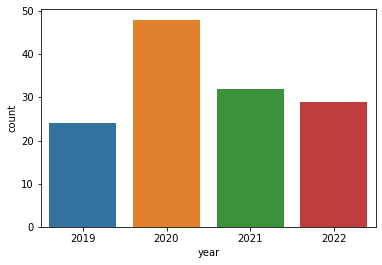

In [30]:
sns.countplot(data=df[cond], x="year")

(130.0, 159.32500000000002)

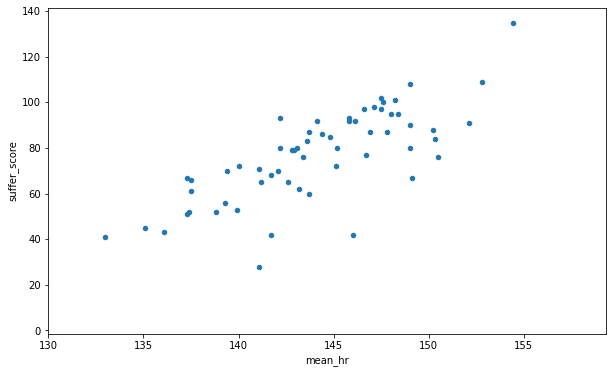

In [39]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
df[cond].plot.scatter(x="mean_hr", y="suffer_score", ax=ax)
#ax.set_ylim(130, None)
ax.set_xlim(130, None)

In [564]:
list(activities)[0].type

'VirtualRide'

data = []
for activity in activities:
    my_dict = activity.to_dict()
    data.append([activity.id]+[my_dict.get(x) for x in my_cols])
    
# Add id to the beginning of the columns, used when selecting a specific activity
my_cols.insert(0,'id')

In [159]:
data_ = client.get_activity_streams(6314126019, types=)

In [160]:
data_.keys()

dict_keys(['distance'])

In [33]:
data_ = client.get_activity_streams(6314126019, types=["time", "heartrate", "watts"])

In [34]:
data_.items()
#data_["distance"].data

dict_items([('watts', <Stream type=watts resolution=high original_size=3578>), ('distance', <Stream type=distance resolution=high original_size=3578>), ('heartrate', <Stream type=heartrate resolution=high original_size=3578>), ('time', <Stream type=time resolution=high original_size=3578>)])

In [35]:
data_

{'watts': <Stream type=watts resolution=high original_size=3578>,
 'distance': <Stream type=distance resolution=high original_size=3578>,
 'heartrate': <Stream type=heartrate resolution=high original_size=3578>,
 'time': <Stream type=time resolution=high original_size=3578>}

In [36]:
empty_dict = {}
for name, stream in data_.items():
    empty_dict[name] = stream.data

In [37]:
df2 = pd.DataFrame(empty_dict)
df2 = df2.astype("float")
print(df2["watts"].isna().sum())
df2 = df2.dropna(subset=["watts"])
df2.head()

1


,watts,distance,heartrate,time
1,138.0,2.1,101.0,1.0
2,138.0,4.3,101.0,2.0
3,139.0,6.7,101.0,3.0
4,140.0,9.8,101.0,4.0
5,140.0,13.4,101.0,5.0


<AxesSubplot:xlabel='watts', ylabel='heartrate'>

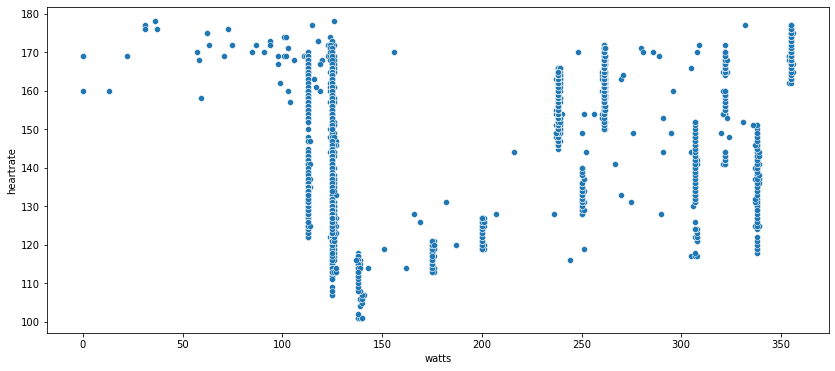

In [50]:
import seaborn as sns
fig, ax = plt.subplots(1,1,figsize=(14,6))
sns.scatterplot(data=df2, x="watts", y="heartrate", ax=ax)

In [197]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

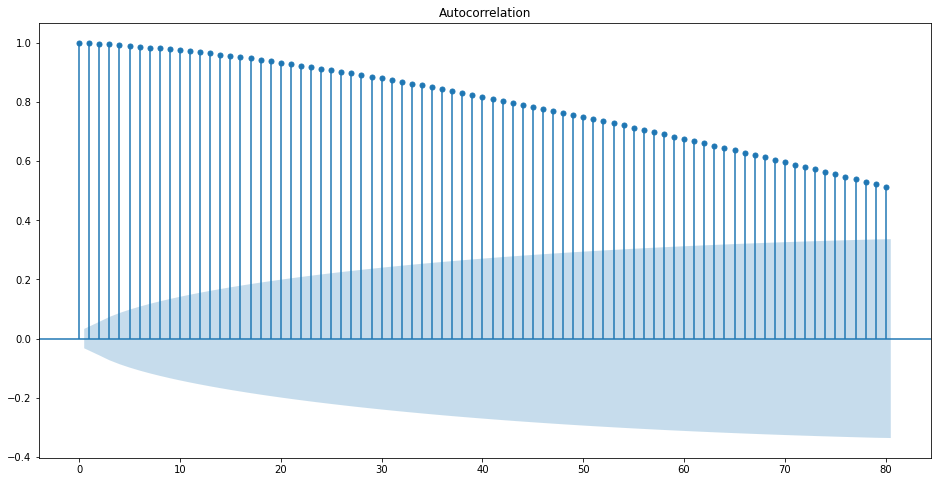

In [194]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
plot_acf(df2["heartrate"], lags=80, ax=ax);

NameError: name 'plot_pacf' is not defined

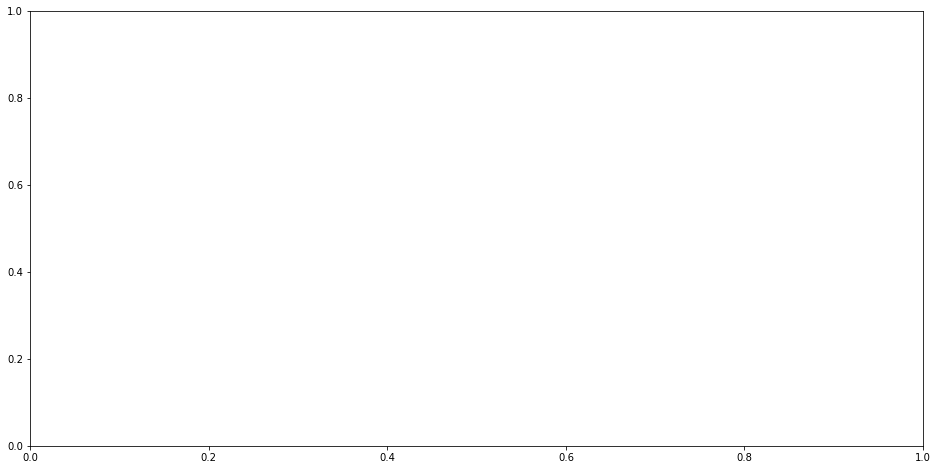

In [38]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
plot_pacf(df2["heartrate"], lags=40, ax=ax);

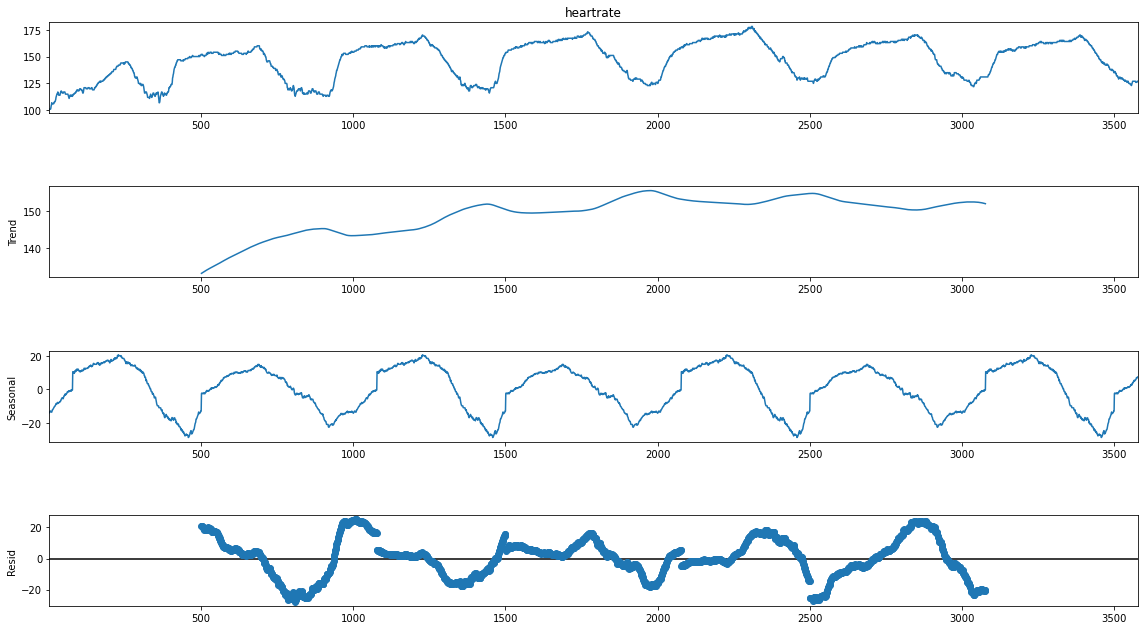

In [228]:
#fig, ax = plt.subplots(1,1, figsize=(16,8))
hej = seasonal_decompose(df["heartrate"], model="add", period=1000).plot()
hej.set_figheight(10)
hej.set_figwidth(18)



<AxesSubplot:>

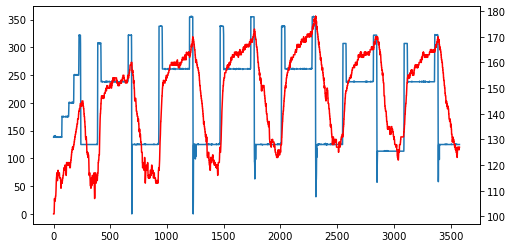

In [52]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
df2["watts"].plot(ax=ax)
ax2 = ax.twinx()
df2["heartrate"].plot(ax=ax2, color="red")

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

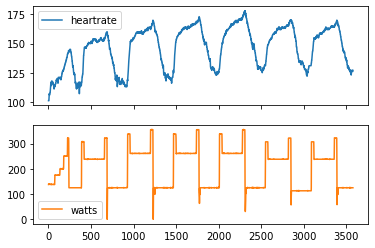

In [53]:
df2[["heartrate", "watts"]].plot(subplots=True)

In [54]:
df2

,watts,distance,heartrate,time
1,138.0,2.1,101.0,1.0
2,138.0,4.3,101.0,2.0
3,139.0,6.7,101.0,3.0
4,140.0,9.8,101.0,4.0
5,140.0,13.4,101.0,5.0
...,...,...,...,...
3573,125.0,30410.5,126.0,3573.0
3574,125.0,30417.3,126.0,3574.0
3575,125.0,30425.2,126.0,3575.0
3576,125.0,30431.7,127.0,3576.0


In [55]:
df2["training"] = df2.watts > 150
df2["training_diff"] = df2.training.diff().fillna(0)
df2["training_diff_cumsum"] = df2.training_diff.cumsum()
df2["time_since_rest"] = df2.groupby("training_diff_cumsum")["training"].transform("cumsum")
df2["joules"] = df2.watts.cumsum()
df2["watts_rolling"] = df2.watts.rolling(100, min_periods=1).mean()#.fillna(method="bfill")

<AxesSubplot:>

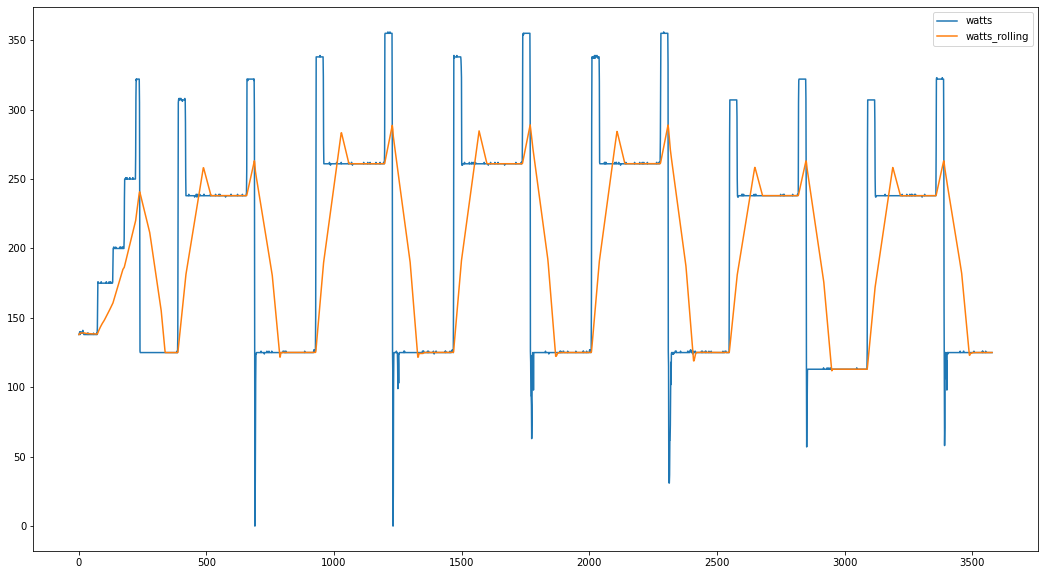

In [56]:
fig, ax = plt.subplots(1,1,figsize=(18,10))
df2[["watts", "watts_rolling"]].plot(subplots=False, ax=ax)

In [57]:
#raw_data = df.drop(columns=["distance", "heartrate"]).copy()
raw_data = df2[["time", "watts", "heartrate", "joules", "watts_rolling"]].copy()

In [58]:
num_train_samples = int(0.6 * len(raw_data))
num_val_samples = int(0.2 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)


num_train_samples: 2146
num_val_samples: 715
num_test_samples: 716


In [439]:
from lightgbm import LGBMRegressor as lgbmr
lgbm = lgbmr()

In [440]:
train_size = int(0.8*len(df))
df_train = df[:train_size]
df_test = df[train_size:]
x_train, y_train = df_train[["watts", "time"]], df_train["heartrate"]
x_test, y_test = df_test[["watts", "time"]], df_test["heartrate"]

In [441]:
lgbm.fit(x_train, y_train)

LGBMRegressor()

In [442]:
preds_test = lgbm.predict(x_test)
preds_train = lgbm.predict(x_train)

In [40]:
import statsmodels.api as sm

In [454]:
#X = sm.add_constant(df[["watts", "time", "time_since_rest"]])
X = sm.add_constant(df[["watts", "time_since_rest"]])
model = sm.OLS(df[:train_size]["heartrate"], X[:train_size])
model = model.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              heartrate   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     1159.
Date:                Tue, 07 Dec 2021   Prob (F-statistic):               0.00
Time:                        23:39:01   Log-Likelihood:                -11554.
No. Observations:                2861   AIC:                         2.311e+04
Df Residuals:                    2858   BIC:                         2.313e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             130.7842      0.860    1

In [456]:
df["linear"] = model.predict(X)

In [457]:
df["train_pred"] = 100
df["test_pred"] = 100
df.loc[df.index <= train_size, "train_pred"] = preds_train
df.loc[df.index > train_size, "test_pred"] = preds_test

<AxesSubplot:>

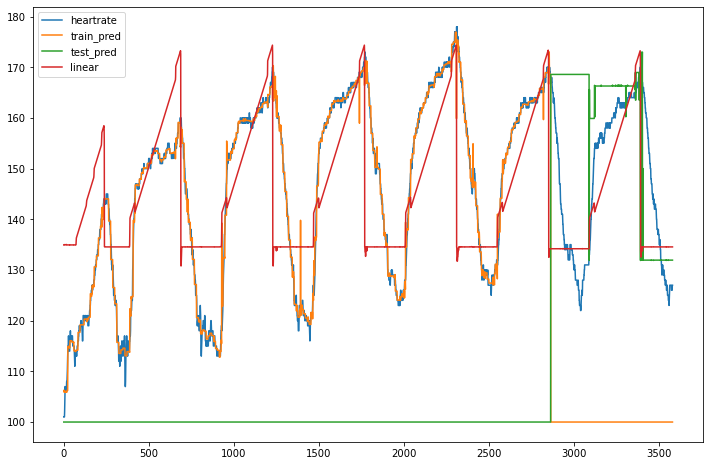

In [458]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
df[["heartrate", "train_pred", "test_pred", "linear"]].plot(ax=ax)

In [61]:
raw_data = raw_data.drop(columns="time").copy()

In [59]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [66]:
temperature = df2["heartrate"]
mean_hr = temperature[:num_train_samples].mean(axis=0)
hr_norm = temperature.copy()
hr_norm -= mean_hr
std_hr = temperature[:num_train_samples].mean(axis=0)
hr_norm /= std_hr

In [ ]:
import numpy as np 
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)
 
for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [67]:
temperature = hr_norm
sampling_rate = 1#6 
sequence_length = 100#120 
delay = sampling_rate * (sequence_length + 1 - 1)
batch_size = 32 
  
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)
  
val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)
  
test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

full_dataset = keras.utils.timeseries_dataset_from_array(
    data = raw_data,
    targets = None,
    shuffle = False,
    sequence_length = sequence_length,
    batch_size=1
)

In [321]:
for samples in full_dataset:
    print("samples shape:", samples.shape)
    break

samples shape: (1, 100, 1)


In [322]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (32, 100, 1)
targets shape: (32,)


In [232]:
def evaluate_naive_method(dataset):
    total_abs_err = 0. 
    samples_seen = 0 
    for samples, targets in dataset:
        #preds = targets[:, -1, 1] * std[1] + mean[1]
        preds = np.mean(targets)
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen
  
print(f"Train MAE: {evaluate_naive_method(train_dataset):.2f}") 
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}") 
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Train MAE: 0.09
Validation MAE: 0.04


ZeroDivisionError: float division by zero

In [295]:

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
  
print(model.summary())
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
] 
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
#model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
  
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 50, 1)]           0         
                                                                 
 flatten_1 (Flatten)         (None, 50)                0         
                                                                 
 dense_13 (Dense)            (None, 16)                816       
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
66/66 [==============================] - 2s 14ms/step - loss: 0.0951 - mae: 0.1624 - val_loss: 0.0490 - val_mae: 0.1469
Epoch 2/10
66/66 [==============================] - 1s 1

In [67]:
raw_data.shape

(3577, 2)

In [150]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 60, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 20, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 4, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [151]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
print(model.summary())
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
  
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 120, 2)]          0         
                                                                 
 conv1d_27 (Conv1D)          (None, 61, 8)             968       
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 30, 8)            0         
 g1D)                                                            
                                                                 
 conv1d_28 (Conv1D)          (None, 11, 8)             1288      
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 5, 8)             0         
 g1D)                                                            
                                                                 
 conv1d_29 (Conv1D)          (None, 2, 8)              264 

In [259]:
raw_data

,watts
0,NaN
1,-0.858203
2,-0.858203
3,-0.844914
4,-0.831626
...,...
3573,-1.030952
3574,-1.030952
3575,-1.030952
3576,-1.030952


In [97]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
#x = layers.LSTM(16)(inputs)
x = layers.Conv1D(filters=30, kernel_size=7, strides=1, padding="causal", activation="relu")(inputs)
x = layers.LSTM(16, return_sequences=True)(x)
x = layers.LSTM(16, return_sequences=False)(x)
x = layers.Dense(8, activation="relu")(x)
#x = layers.Dense(1)

outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='loss', patience=5)
    #keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch/20))
]
opt = keras.optimizers.Adam(learning_rate=0.001)
#model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
model.compile(optimizer=opt, loss="mse", metrics=["mae", "mse"])
print(model.summary())
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_lstm.keras") 
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 100, 4)]          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 100, 30)           870       
                                                                 
 lstm_12 (LSTM)              (None, 100, 16)           3008      
                                                                 
 lstm_13 (LSTM)              (None, 16)                2112      
                                                                 
 dense_11 (Dense)            (None, 8)                 136       
                                                                 
 dense_12 (Dense)            (None, 1)                 9         
                                                                 
Total params: 6,135
Trainable params: 6,135
Non-trainable p

In [100]:
from tensorflow.python.keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


(-0.0001, 0.002)

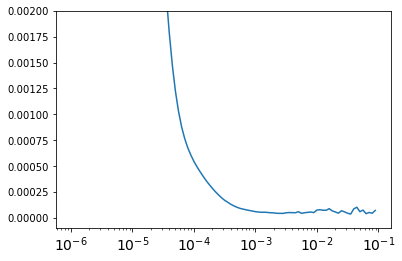

In [92]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.xticks(fontsize=14);
plt.ylim(-0.0001, 0.002)
#plt.axis([1e-8, 1e-4, 0, 30])

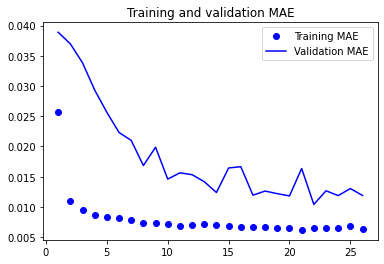

In [98]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

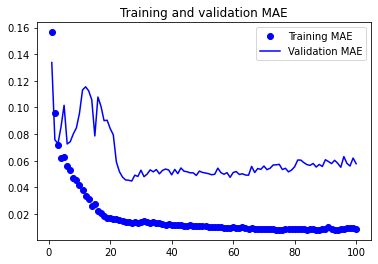

In [210]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [71]:
model.evaluate(val_dataset)

20/20 [==============================] - 0s 8ms/step - loss: 9.0820e-04 - mae: 0.0224 - mse: 9.0820e-04


[0.0009082037140615284, 0.02236301638185978, 0.0009082037140615284]

In [72]:
model.evaluate(test_dataset)

17/17 [==============================] - 0s 9ms/step - loss: 0.0017 - mae: 0.0338 - mse: 0.0017


[0.001651681843213737, 0.03383307158946991, 0.001651681843213737]

In [73]:
test = model.predict(full_dataset)
test

array([[-0.17310119],
       [-0.16898991],
       [-0.16760224],
       ...,
       [-0.2265367 ],
       [-0.22493716],
       [-0.22468272]], dtype=float32)

In [74]:
test.squeeze(1)#.shape

array([-0.17310119, -0.16898991, -0.16760224, ..., -0.2265367 ,
       -0.22493716, -0.22468272], dtype=float32)

In [75]:
test * std_hr + mean_hr

array([[117.97026 ],
       [118.55679 ],
       [118.75477 ],
       ...,
       [110.34683 ],
       [110.575035],
       [110.61133 ]], dtype=float32)

In [78]:
len(df2) - len(test)

99

In [79]:
df2.loc[df2.index > 99, "lstm"] = test.squeeze(1) * std_hr + mean_hr
df2.lstm.fillna(100, inplace=True)
df2.lstm = df2.lstm.astype("float")

In [ ]:
print(int(len(df) - 0.1*len(df)))
print(int(len(df) - 0.2*len(df)))

3219
2861


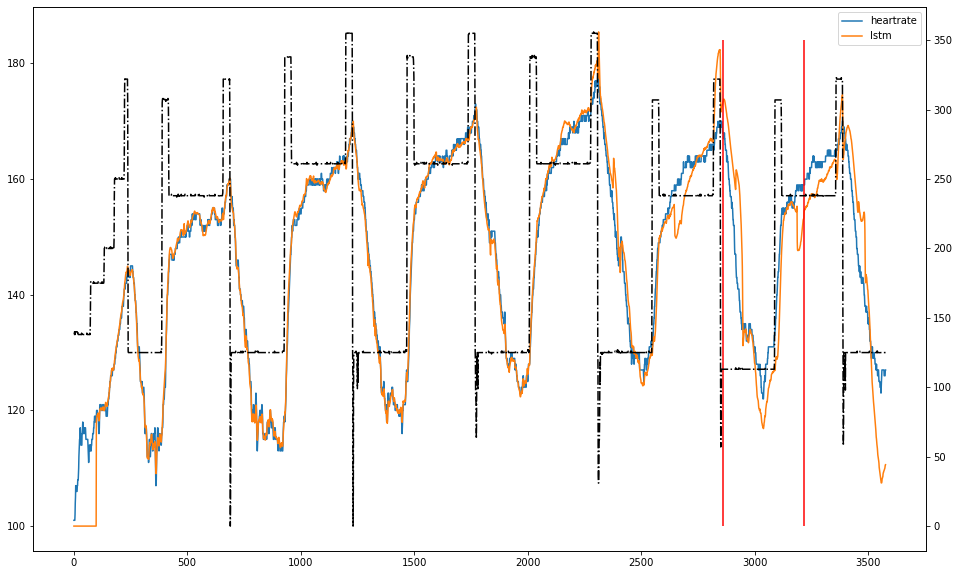

In [81]:
fig, ax = plt.subplots(1,1, figsize=(16,10))
ax2 = ax.twinx()
#df[["heartrate", "train_pred", "test_pred", "linear", "lstm"]].plot(ax=ax)
df2[["heartrate", "lstm"]].plot(ax=ax)
df2["watts"].plot(ax=ax2, label="watts", color="black", linestyle="-.")
ax2.vlines(3219, 0, 350, color="red")
ax2.vlines(2861, 0, 350, color="red")

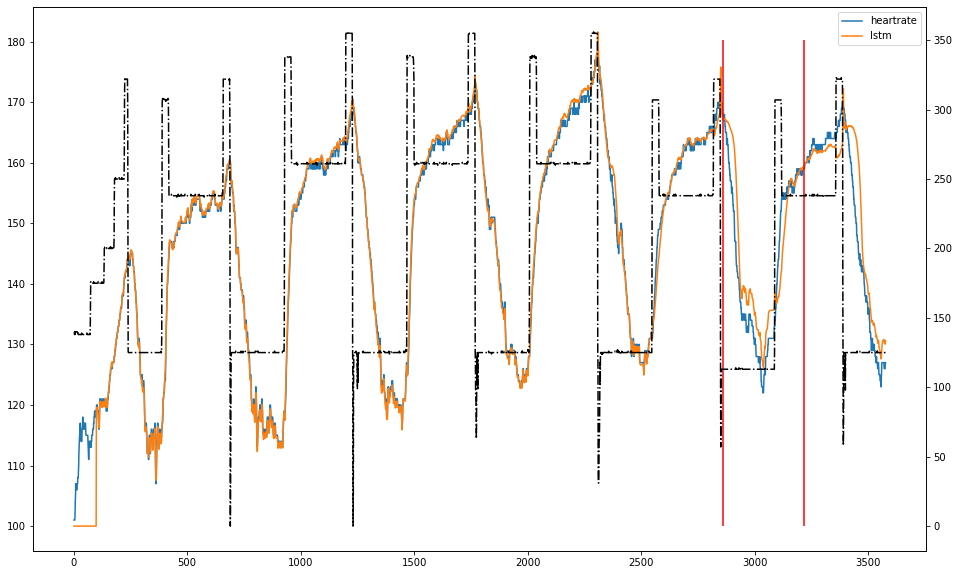

In [539]:
fig, ax = plt.subplots(1,1, figsize=(16,10))
ax2 = ax.twinx()
#df[["heartrate", "train_pred", "test_pred", "linear", "lstm"]].plot(ax=ax)
df[["heartrate", "lstm"]].plot(ax=ax)
df["watts"].plot(ax=ax2, label="watts", color="black", linestyle="-.")
ax2.vlines(3219, 0, 350, color="red")
ax2.vlines(2861, 0, 350, color="red")

<AxesSubplot:>

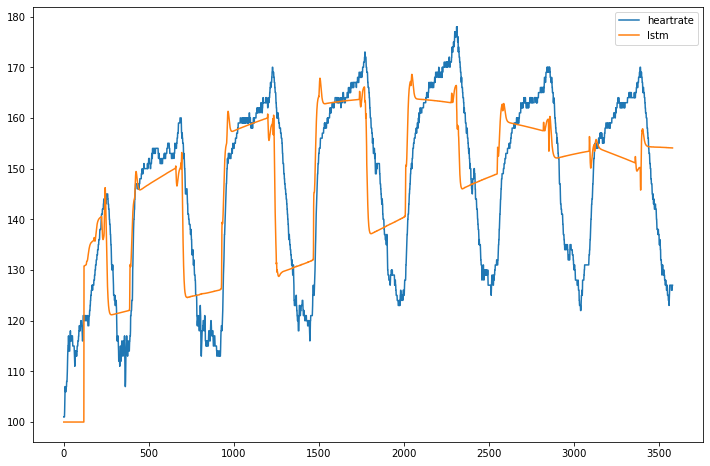

In [140]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
#df[["heartrate", "train_pred", "test_pred", "linear", "lstm"]].plot(ax=ax)
df[["heartrate", "lstm"]].plot(ax=ax)